Problem statement: **Data Wrangling II**
* Create an "Academic performance" dataset of students.
* Scan all variables for missing values and inconsistencies.
* Handle missing values and inconsistencies using suitable techniques.
* Apply data transformations on at least one variable for:
  * Scaling the variable for better understanding.
  * Converting non-linear relations to linear.
  * Reducing skewness and making the distribution normal.

# Import necessary Libraries

In [1]:
import pandas as pd
import numpy as np

# Create DataFrame

### **pd.DataFrame()**
**Creates a 2-dimensional labeled data structure with columns of potentially different types, akin to a spreadsheet or SQL table.**

Output: A pandas DataFrame object.

Parameters:
<table>
  <thead>
    <tr>
      <th>Parameter</th>
      <th>Description</th>
      <th>Typical Use Case</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>data</code></td>
      <td>Data to be stored in the DataFrame (e.g., dict, list, ndarray).</td>
      <td>Providing the actual data for the DataFrame.</td>
    </tr>
    <tr>
      <td><code>columns</code></td>
      <td>Column labels for the DataFrame.</td>
      <td>Specifying custom column names.</td>
    </tr>
  </tbody>
</table>

When to Use: Utilize pd.DataFrame() when you need to create a DataFrame from scratch or from various data structures like lists, dictionaries, or NumPy arrays.

In [2]:
data = {
    "StudentID": [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
    "Name": ["Alice", "Bob", "Charlie", "David", "Eva", "Frank", "Grace", "Hank", "Ivy", "Jake"],
    "MathScore": [85, 92, np.nan, 88, 45, 39, 102, 77, 90, 80],  # includes missing and outlier
    "EnglishScore": [78, 82, 79, 85, 50, 40, 65, 80, np.nan, 75],  # includes missing value
    "AttendanceRate": [0.95, 0.85, 0.80, 0.90, 0.92, 0.50, 1.05, 0.87, 0.89, 0.91]  # includes inconsistency
}

df = pd.DataFrame(data)

In [3]:
df

,StudentID,Name,MathScore,EnglishScore,AttendanceRate
0,101,Alice,85.0,78.0,0.95
1,102,Bob,92.0,82.0,0.85
2,103,Charlie,NaN,79.0,0.80
3,104,David,88.0,85.0,0.90
4,105,Eva,45.0,50.0,0.92
5,106,Frank,39.0,40.0,0.50
6,107,Grace,102.0,65.0,1.05
7,108,Hank,77.0,80.0,0.87
8,109,Ivy,90.0,NaN,0.89
9,110,Jake,80.0,75.0,0.91


# Find Missing Value and Fill Missing Data

### **fillna()**
Fills missing (NaN) values in a DataFrame with specified values or methods.

Output: A DataFrame with missing values filled according to the specified parameters.

</strong> By applying <code>fillna()</code> to individual columns like <code>MathScore</code> and <code>EnglishScore</code>, each column’s missing values are filled independently using its own mean.

### **clip()**
Limits the values in a DataFrame to a specified range, setting values below a lower bound to the lower bound and values above an upper bound to the upper bound.

Output: A DataFrame with values clipped to the specified range.

In [4]:
df.isnull().sum()

StudentID         0
Name              0
MathScore         1
EnglishScore      1
AttendanceRate    0
dtype: int64

In [5]:
df['MathScore'].mean()

77.55555555555556

In [6]:
# Filling missing MathScore and EnglishScore with mean (simple imputation)
df["MathScore"] = df["MathScore"].fillna(df["MathScore"].mean())
df["EnglishScore"] = df["EnglishScore"].fillna(df["EnglishScore"].mean())

In [7]:
# Fixing inconsistency in AttendanceRate (clip values between 0 and 1)
df["AttendanceRate"] = df["AttendanceRate"].clip(0, 1)

# Outlier Detection

<ul>
  <li><strong>Purpose:</strong> Detect outliers in <code>MathScore</code> using the IQR method.</li>
  <li><strong>Method:</strong> Compute Q1 and Q3 using <code>quantile()</code>, then calculate <code>IQR = Q3 - Q1</code>.</li>
  <li><strong>Outlier Bounds:</strong> Values below <code>Q1 - 1.5×IQR</code> or above <code>Q3 + 1.5×IQR</code> are outliers.</li>
  <li><strong>Detection:</strong> Loop through <code>MathScore</code> and collect values outside the bounds.</li>
</ul>


In [8]:
# Use IQR method to detect outliers in MathScore
Q1 = df["MathScore"].quantile(0.25)
Q3 = df["MathScore"].quantile(0.75)
IQR = Q3 - Q1

In [9]:
# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [10]:
outliers = []
for x in df["MathScore"]:
    if (x < lower_bound or x > upper_bound):
        outliers.append(x)

print("Outliers in MathScore are:", outliers)

Outliers in MathScore are: [45.0, 39.0]


In [11]:
import seaborn as sns

<Axes: xlabel='MathScore'>

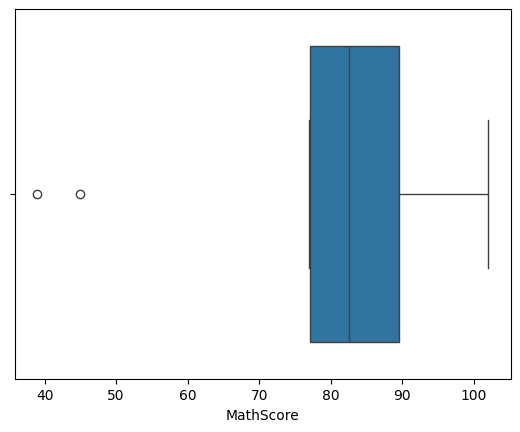

In [12]:
sns.boxplot(df['MathScore'], orient='h')

# Outlier Removal

<ul>
  <li>We are capping (or winsorizing) outliers in <code>MathScore</code> to reduce their effect by replacing extreme values with threshold limits.</li>
  <li><strong>How We Are Doing:</strong> Using an <code>if-else</code> loop, values above <code>upper_bound</code> are set to <code>upper_bound</code>, and values below <code>lower_bound</code> are set to <code>lower_bound</code>.</li>
  <li> The original <code>MathScore</code> column is updated with the capped values.</li>
</ul>


In [13]:
#Cap the outliers using if-else in loop
capped_scores = []

for score in df["MathScore"]:
    if score > upper_bound:
        capped_scores.append(upper_bound)
    elif score < lower_bound:
        capped_scores.append(lower_bound)
    else:
        capped_scores.append(score)

In [14]:
# Step 3: Replace the column with capped values
df["MathScore"] = capped_scores

<Axes: xlabel='MathScore'>

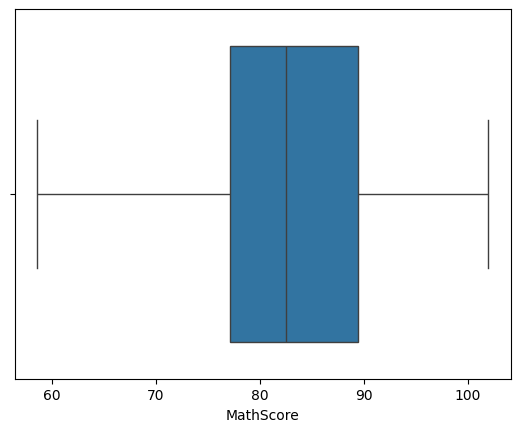

In [15]:
sns.boxplot(df['MathScore'], orient='h')

# Data Transformation

PowerTransformer is part of scikit-learn’s sklearn.preprocessing module and implements two parametric, monotonic transformations—**Box-Cox (requires strictly positive data)** and **Yeo-Johnson (handles zero & negative values)**—to map features toward a normal distribution.

**Mathematical Formulas:**  

1) **Box-Cox Transformation**(for positive data):
<p>
  For a feature value \( x \) and parameter \( \lambda \):
  <br>
  \( x_{\text{trans}} = \begin{cases}
    \frac{x^\lambda - 1}{\lambda}, & \text{if } \lambda \ne 0 \\
    \log(x), & \text{if } \lambda = 0
  \end{cases} \)
</p>


2) **Yeo-Johnson Transformation** (for positive and negative data):
<p>
  For a feature value \( x \) and parameter \( \lambda \):
  <br>
  \( x_{\text{trans}} = \begin{cases}
    \frac{(x + 1)^\lambda - 1}{\lambda}, & \text{if } x \ge 0, \lambda \ne 0 \\
    \log(x + 1), & \text{if } x \ge 0, \lambda = 0 \\
    -\frac{(-x + 1)^{2 - \lambda} - 1}{2 - \lambda}, & \text{if } x < 0, \lambda \ne 2 \\
    -\log(-x + 1), & \text{if } x < 0, \lambda = 2
  \end{cases} \)
</p>

        
**When to Use:**
- Data Normalization: When features are not normally distributed and normalization is required.  
- Variance Stabilization: To stabilize variance across features.  

In [16]:
from sklearn.preprocessing import PowerTransformer

In [17]:
pt = PowerTransformer()

In [18]:
df['Transformed_AttendanceRate'] = pt.fit_transform(df[['AttendanceRate']])

In [19]:
print(df[['Name', 'AttendanceRate', 'Transformed_AttendanceRate']])

      Name  AttendanceRate  Transformed_AttendanceRate
0    Alice            0.95                    0.908993
1      Bob            0.85                   -0.457886
2  Charlie            0.80                   -0.913387
3    David            0.90                    0.137142
4      Eva            0.92                    0.422303
5    Frank            0.50                   -2.043523
6    Grace            1.00                    1.903561
7     Hank            0.87                   -0.238532
8      Ivy            0.89                    0.005298
9     Jake            0.91                    0.276031
